In [1]:
import numpy as np
import corner
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc
plt.rcParams['font.family'] = 'DejaVu Sans'
rc('text', usetex=True)
plt.rcParams.update({'font.size': 19})
import emcee
import math
import h5py
import inspect
import pandas as pd
import json
import qnm
import random
from scipy.optimize import minimize

### <font text color = 'Goldenrod'>Import data and preliminary functions</font>

In [2]:
#TimeOfMaximum
def FindTmaximum(y):
    #Determines the maximum absolute value of the complex waveform
    absval = y[:,1]*y[:,1]+y[:,2]*y[:,2]
    vmax=np.max(absval)
    index = np.argmax(absval == vmax)
    timemax=gw_sxs_bbh_0305[index,0]
    return timemax

# You do not need that. This is a fit to the energy radiated = 1 - final_mass
def EradUIB2017(eta,chi1,chi2):
    
    m1=0.5*(1+(1-4*eta)**0.5)
    m2=0.5*(1-(1-4*eta)**0.5)
    S= (m1**2*chi1 + m2**2*chi2)/(m1*m1 + m2*m2)
    
    erad=(((1-(2*(2)**0.5)/3)*eta+0.5609904135313374*eta**2-0.84667563764404*eta**3+3.145145224278187*eta**4)*(1+S**3 *(-0.6320191645391563+ 4.952698546796005*eta-10.023747993978121*eta**2)+S**2*(-0.17762802148331427+ 2.176667900182948*eta**2)+S*(-0.13084389181783257- 1.1387311580238488*eta+5.49074464410971*eta**2)))/(1+S*(-0.9919475346968611+ 0.367620218664352*eta+4.274567337924067*eta**2))-0.01978238971523653*S*(1-4.91667749015812*eta)*(1-4*eta)**0.5 *eta *(chi1-chi2)-0.09803730445895877*(1-4*eta)**0.5*(1-3.2283713377939134*eta)*eta**2 *(chi1-chi2)+0.01118530335431078*eta**3 *(chi1-chi2)**2
    return erad

In [20]:
#rootpath: root path to nr data
#npoints: number of points you re using for your sampling
#nmax: tone index --> nmax = 0 im fitting the fundamental tone
#tshift: time shift after the strain peak
rootpath="/Users/RayneLiu"
#npoints=5000 (This is more conveniently defined in the MCMC section)
nmax=1
tshift=19

In [21]:
#This loads the 22 mode data
gw = {}
gw["SXS:BBH:0305"] = h5py.File(rootpath+"/git/rdstackingproject/SXS/BBH_SKS_d14.3_q1.22_sA_0_0_0.330_sB_0_0_-0.440/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5", 'r')
gw_sxs_bbh_0305 = gw["SXS:BBH:0305"]["Extrapolated_N2.dir"]["Y_l2_m2.dat"]

# Remember to download metadata.json from the simulation with number: 0305. Download Lev6/metadata.json
# This postprocesses the metadata file to find the final mass and final spin
metadata = {}
with open(rootpath+"/git/rdstackingproject/SXS/BBH_SKS_d14.3_q1.22_sA_0_0_0.330_sB_0_0_-0.440/Lev6/metadata.json") as file:
    metadata["SXS:BBH:0305"] = json.load(file)

af = metadata["SXS:BBH:0305"]['remnant_dimensionless_spin'][-1]
mf = metadata["SXS:BBH:0305"]['remnant_mass']

In [22]:
#times --> x axis of your data
times = gw_sxs_bbh_0305[:,0]
tmax=FindTmaximum(gw_sxs_bbh_0305)
t0=tmax +tshift

#Select the data from t0 onwards
position = np.argmax(times >= (t0))
gw_sxs_bbh_0305rd=gw_sxs_bbh_0305[position:-1]
timesrd=gw_sxs_bbh_0305[position:-1][:,0]

# Depending on nmax, you load nmax number of freqs. and damping times from the qnm package
omegas = []
for i in range (0,nmax+1):
    grav_220 = qnm.modes_cache(s=-2,l=2,m=2,n=i)
    omega = grav_220(a=af)[0]
    omegas.append(omega)

In [23]:
'''
a = np.array([[1, 2],[3, 4],[5, 6],[7, 8]])
a[1,0] #This is just the element 3
a[:,0] #This is like TakeColumn[#, 0]
b = a.flatten()
b
b[1::3] #This takes the element every 3-1 other element, starting from position 1
'''

'\na = np.array([[1, 2],[3, 4],[5, 6],[7, 8]])\na[1,0] #This is just the element 3\na[:,0] #This is like TakeColumn[#, 0]\nb = a.flatten()\nb\nb[1::3] #This takes the element every 3-1 other element, starting from position 1\n'

### <font text color = 'Goldenrod'>Fitting with scipy</font>

In [24]:
#Functions

#RD model for nmax tones. Amplitudes are in (xn*Exp[i yn]) version. Used here.
def model_dv_af(theta):
    #x0, y0= theta
    #Your nmax might not align with the dim of theta. Better check it here.
    assert int(len(theta)/4) == nmax + 1, 'Please recheck your n and parameters'
    w = (np.real(omegas))/mf
    tau=-1/(np.imag(omegas))*mf
    dim =int(len(theta)/4)        
    
    xvars = [theta[4*i] for i in range (0, dim)]
    yvars = [theta[4*i+1] for i in range (0, dim)]
    avars = [theta[4*i+2] for i in range (0, dim)]
    bvars = [theta[4*i+3] for i in range (0, dim)]        
    
    ansatz = 0
    for i in range (0,dim):
        #bvars[0]=0
        #avars[0]=0
        #bvars[1]=0
        #avars[1]=0
        ansatz += (xvars[i]*np.exp(1j*yvars[i]))*np.exp(-(timesrd-timesrd[0])/(tau[i]*(1+bvars[i])))\
        *(np.cos((1+avars[i])*w[i]*timesrd)-1j*np.sin((1+avars[i])*w[i]*timesrd))
    # -1j to agree with SXS convention
    return ansatz


# LogLikelihood function. It is just a Gaussian loglikelihood based on computing the residuals^2
def log_likelihood(theta):
    #modelev = model_dv(theta)
    modelev = model_dv_af(theta)
    
    return  -np.sum((gw_sxs_bbh_0305rd[:,1] - (modelev.real))**2+(gw_sxs_bbh_0305rd[:,2] - (modelev.imag))**2)


# LogLikelihood match function. Not used at the moment. It is just a Gaussian match loglikelihood based on computing the match
'''def log_likelihood_match(theta):
    
    #model and data
    modelev = model_dv(theta)
    data = gw_sxs_bbh_0305rd[:,1] - 1j*gw_sxs_bbh_0305rd[:,2]
    
    #norms
    norm1=np.sum(modelev*np.conj(modelev))
    norm2=np.sum(data*np.conj(data))

    #mismatch
    myTable = data*np.conj(modelev);    
    return -(1-(np.sum(myTable)).real/np.sqrt(norm1*norm2)).real'''


# Logposterior distribution for the residuals case.
# The evidence is just a normalization factor
def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)


# Logposterior distribution for the mismatch case. Not used yet.
'''def log_probability_match(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_match(theta)'''


# Logprior distribution. It defines the allowed range my variables can vary over. 
#It works for the (xn*Exp[iyn]) version!!! 
def log_prior(theta):
    x_s = theta[0::4]
    y_s = theta[1::4]
    a_s = theta[2::4]
    b_s = theta[3::4]
    if all(0 <= t <= 10 for t in x_s) and all(0 <= t <= 2*np.pi for t in y_s) and all(-0.4 <= t <= 0.4 for t in a_s) and all(-0.4 <= t <= 0.4 for t in b_s):
        return 0.0
    return -np.inf

Maximum estimator Fitting. Same use as in mathematica

In [26]:
#I need to provide an initial guess for 4*(nmax+1) the parameters
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
#This assigns the initial guess
initial_block = np.array([1,1,0,0])
initial = np.tile(initial_block, nmax+1)
soln = minimize(nll, initial)
#x0_ml, y0_ml, a0_ml, b0_ml = soln.x
print("Maximum likelihood estimates:") #Maximum likelihood: minimum -log_likelihood. Log_likelihood is easier to calculate
vars_ml=soln.x
print(vars_ml)

Maximum likelihood estimates:
[ 0.0044366   0.99947869  0.80500705  0.47259737 -0.26033925  1.00049473
 -0.6114346  -0.96435967]


/Users/RayneLiu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in square
/Users/RayneLiu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in exp
/Users/RayneLiu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in multiply
/Users/RayneLiu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in add


In [64]:
#SAVE THIS CELL. OVERFLOW HAPPENED FOR N=1
#I need to provide an initial guess for 4*(nmax+1) the parameters
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
#This assigns the initial guess
initial_block = np.array([1,1,0,0])
initial = np.tile(initial_block, nmax+1)
soln = minimize(nll, initial)
#x0_ml, y0_ml, a0_ml, b0_ml = soln.x
print("Maximum likelihood estimates:") #Maximum likelihood: minimum -log_likelihood. Log_likelihood is easier to calculate
vars_ml=soln.x
print(vars_ml)

Maximum likelihood estimates:
[ 0.0044366   0.99947869  0.80500705  0.47259737 -0.26033925  1.00049473
 -0.6114346  -0.96435967]


/Users/RayneLiu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in square
/Users/RayneLiu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp
/Users/RayneLiu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in multiply
/Users/RayneLiu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in add


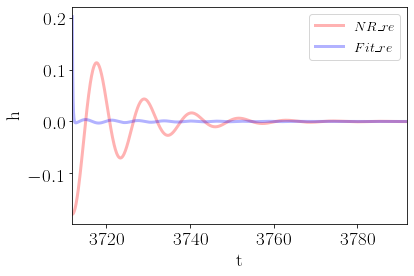

In [27]:
#Now plot the NR data against the ansatz data
plt.plot(timesrd, gw_sxs_bbh_0305rd[:,1], "r", alpha=0.3, lw=3, label=r'$NR\_re$')
modelfit = model_dv_af(vars_ml)
plt.plot(timesrd, modelfit.real,"b", alpha=0.3, lw=3, label=r'$Fit\_re$')
#plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(timesrd[0], timesrd[0]+80)
plt.xlabel("t")
plt.ylabel("h");

### <font text color = 'Goldenrod'>MCMC Fit</font>

In [15]:
#Define your initial position of your 4*(nmax+1) variables.
nwalkers = 32
ndim = int(4*(nmax+1))
npoints = 30000

pos = [random.uniform(0.01,10),random.uniform(0,2*np.pi),random.uniform(-0.1,0.1),random.uniform(-0.1,0.1)] * (nmax+1)
pos += 1e-3 * np.random.randn(nwalkers, ndim)

In [16]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
sampler.run_mcmc(pos,npoints,progress=True);

100%|██████████| 30000/30000 [01:41<00:00, 294.42it/s]


In [17]:
sampler.chain[:, :, 0].T.shape

(30000, 32)

In [18]:
paramlabels = []
for i in range (nmax+1):
    sublabel = [r'$x_' + str(i) + '$', r'$y_' + str(i) + '$', r'$\alpha_' + str(i) + '$',r'$\beta_' + str(i) + '$']
    paramlabels += sublabel

### <font text color = '#63C2F5'>$n = 0$</font>

<Figure size 432x288 with 0 Axes>

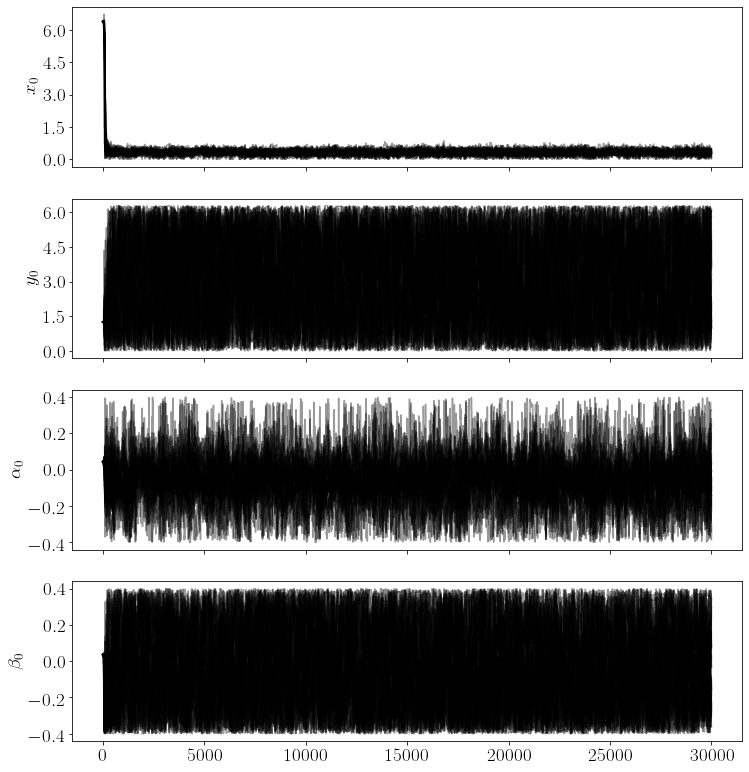

In [23]:
plt.clf()
fig, axes = plt.subplots(4*(nmax+1), 1, sharex=True, figsize=(12, 13.5*(nmax+1)))
for i in range(4*(nmax+1)):
    axes[i].plot(sampler.chain[:, :, i].T, color="k", alpha=0.4)
    axes[i].yaxis.set_major_locator(MaxNLocator(5))
    axes[i].set_ylabel(paramlabels[i])
plt.show()

[ 0.33316833  3.04479916 -0.05377048 -0.03172303]
[ 3.41648660e-01 -2.20431377e+03 -4.46779067e-02  1.17854848e-01]


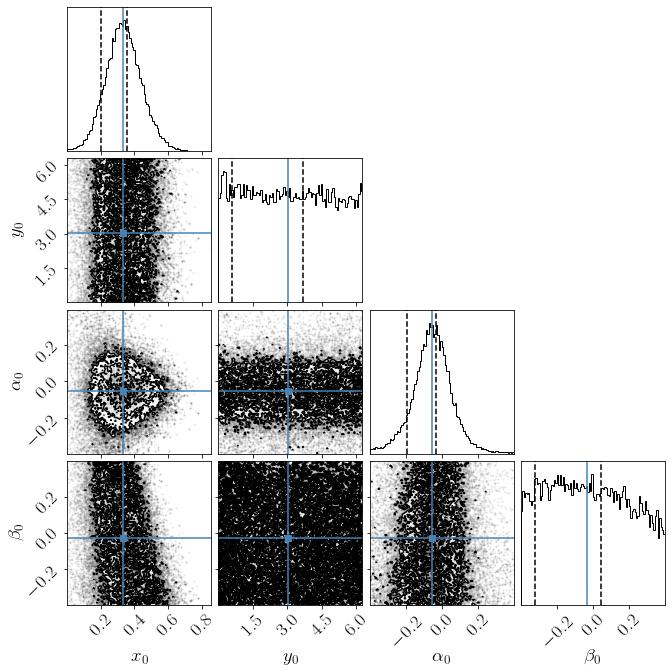

In [24]:
burnin = 2000
flat_samples = sampler.get_chain(discard=burnin, thin=15, flat=True)
median=np.median(sampler.flatchain, axis=0)
#argmax = np.argmax(sampler.flatchain, axis=0)
print(median)
#print(argmax)
print(vars_ml)

fig = corner.corner(
    flat_samples, bins=100, labels=paramlabels, truths=median,quantiles=(0.1, 0.6)
);

### <font text color = '#63C2F5'>$n = 1$ - varying the fundamental frequency - bug happened</font>

### <font text color = 'Goldenrod'> Plot the MCMC Fitting signals </font>

In [28]:
#Find the parameters corresponding to the peak value of lglk
lglk = np.array([log_likelihood(flat_samples[i]) for i in range(len(flat_samples))])

pk = flat_samples[np.argmax(lglk)]
log_likelihood(pk)

-0.07233172030683817

In [29]:
log_likelihood(vars_ml)

-0.06660998359811479

In [43]:
#Get the upper and lower bounds
#nintyp_bounds = np.array([np.percentile(flat_samples[:, i], [5, 95]) for i in range(len(flat_samples[0]))]).T
onesig_bounds = np.array([np.percentile(flat_samples[:, i], [16, 84]) for i in range(len(flat_samples[0]))]).T

In [44]:
print(onesig_bounds.T)

[[ 0.22946754  0.43958258]
 [ 0.94379037  5.23411548]
 [-0.1552579   0.04391289]
 [-0.27594387  0.2408857 ]]


In [45]:
onesig_bounds

array([[ 0.22946754,  0.94379037, -0.1552579 , -0.27594387],
       [ 0.43958258,  5.23411548,  0.04391289,  0.2408857 ]])

In [50]:
np.all(flat_samples[0] <= onesig_bounds[1])

True

### <font text color = '#63C2F5'>$n = 0$</font>

In [31]:
#Get the constraints in numbers of the parameters
from IPython.display import display, Math

labels = [r'x_0', r'y_0', r'\alpha_0', r'\beta_0']
for i in range(len(flat_samples[0])):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    #print(mcmc)
    q = np.diff(mcmc)
    #print(q)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Text(0, 0.5, 'h')

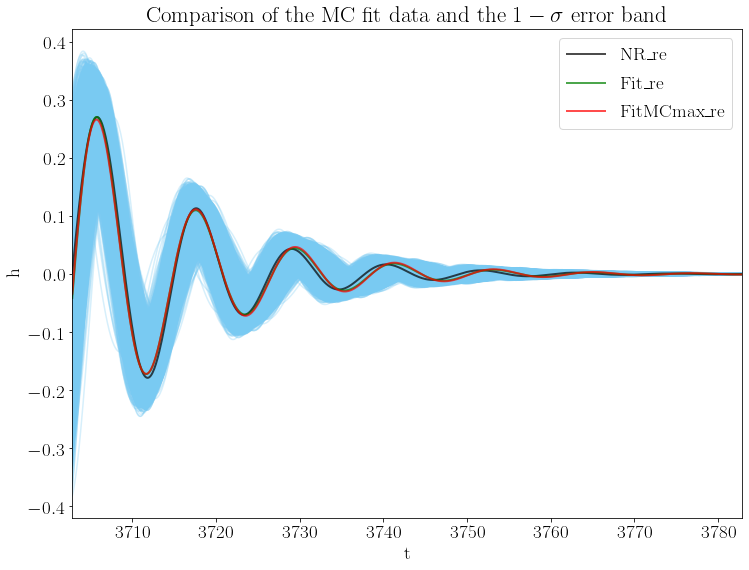

In [57]:
#Now plot the NR data against the ansatz data, together with the 1-sigma varying error data

modelfit = model_dv_af(vars_ml)
#modelfitmed = model_dv_af(median)
modelfitpk = model_dv_af(pk)


fig = plt.figure(figsize = (12, 9))
#Plot the 90-percentile
for j in range(len(flat_samples)):
    sample = flat_samples[j]
    if np.all(onesig_bounds[0] <= sample) and np.all(sample <= onesig_bounds[1]):
        plt.plot(timesrd, model_dv_af(sample).real, "#79CAF2", alpha=0.3)

    
plt.plot(timesrd, gw_sxs_bbh_0305rd[:,1], "k", alpha=0.7, lw=2, label=r'NR\_re')
plt.plot(timesrd, modelfit.real, "g", alpha=0.7, lw=2, label=r'Fit\_re')
plt.plot(timesrd, modelfitpk.real, "r", alpha=0.7, lw=2, label=r'FitMCmax\_re')
plt.title(r'Comparison of the MC fit data and the $1-\sigma$ error band')
plt.legend()
plt.xlim(timesrd[0], timesrd[0]+80)
plt.xlabel("t")
plt.ylabel("h");
#fig.savefig(rootpath+'/git/rdstackingproject/plots/fit_signal.pdf', format = 'pdf')

### <font text color = '#63C2F5'>$n = 1$ - varying the fundamental frequency</font>

n=1 both fixing 0's and varying them; find the tshift starting from which the 1-sigma band is the smallest;
find the time from which the systematic error outweighs the statistic error

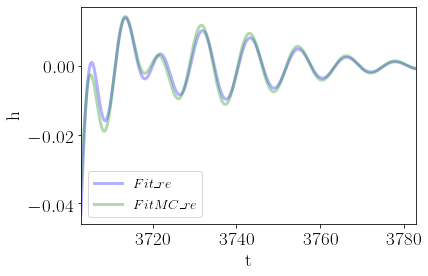

In [59]:
#Now plot the NR data against the ansatz data
#plt.plot(timesrd, gw_sxs_bbh_0305rd[:,1], "r", alpha=0.3, lw=3, label=r'$NR\_re$')
modelfit = model_dv_af(vars_ml)
modelfitpk = model_dv_af(pk)
plt.plot(timesrd, modelfit.real-gw_sxs_bbh_0305rd[:,1], "b", alpha=0.3, lw=3, label=r'$Fit\_re$')
plt.plot(timesrd, modelfitpk.real-gw_sxs_bbh_0305rd[:,1], "g", alpha=0.3, lw=3, label=r'$FitMC\_re$')
#plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(timesrd[0], timesrd[0]+80)
plt.xlabel("t")
plt.ylabel("h");

[ 3.32589172e-01  5.31725794e+00 -3.13654471e-02 -2.58078075e-02
  4.71483299e-01  4.04531738e+00  2.03280121e-03 -5.51589650e-02
  4.61456132e-01  3.73712949e+00  3.31282609e-03  3.16237321e-02]
[ 0.34660873 -0.76574725  0.          0.          0.03079226  0.95180188
 -0.29620469 -0.28913395  0.14522677  0.62909469  0.06566913  0.77523626]


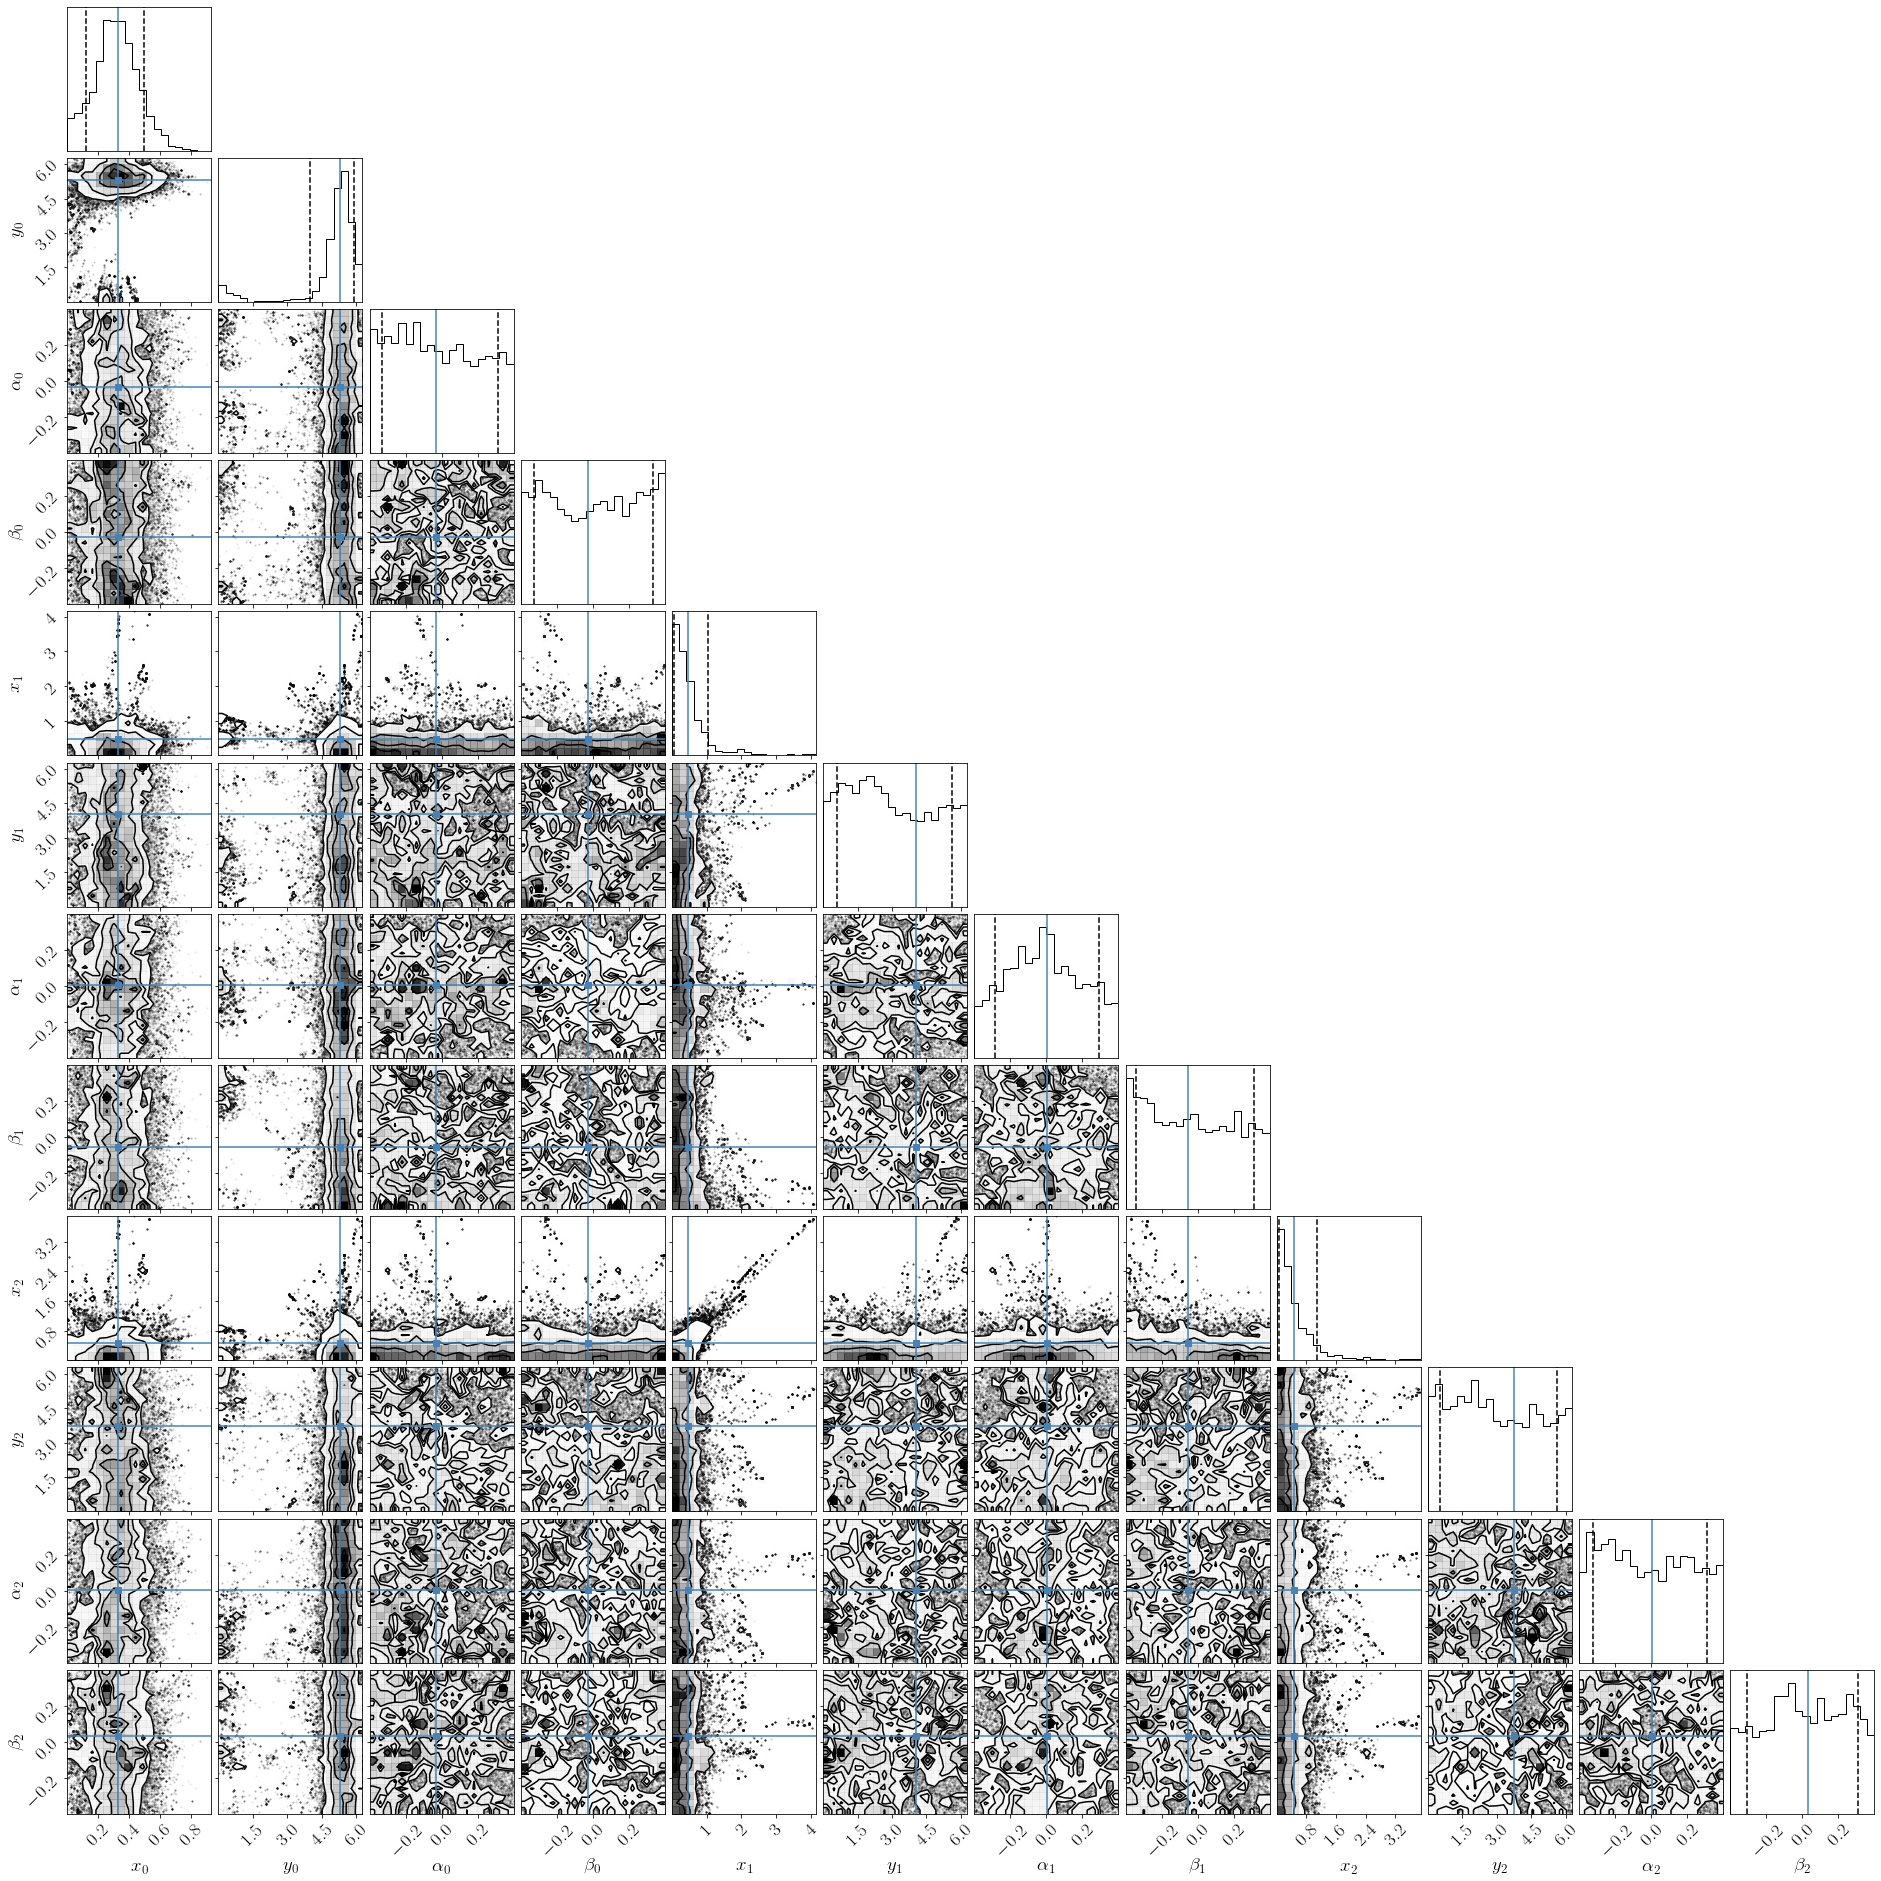

In [16]:
burnin = 20000
flat_samples = sampler.get_chain(discard=burnin, thin=15, flat=True)
median=np.median(sampler.flatchain, axis=0)
print(median)
print(vars_ml)

fig = corner.corner(
    flat_samples, labels=paramlabels, truths=median,quantiles=(0.1, 0.9)
);

In [17]:
#Change that as well!!!
fig.savefig(rootpath+'/git/rdstackingproject/plots/chi2_nmax='+str(nmax)+'_emcee.pdf')

In [44]:
#Output this as well!!!
flat_samples_T=flat_samples.T
cov_matr=np.cov(flat_samples_T)
columns=list(range(1, len(flat_samples_T)+1))
print('Covariant matrix')
df = pd.DataFrame(cov_matr,columns=columns)
df

Covariant matrix


1         2         3         4
0  0.008780 -0.000062  0.000389  0.000205
1 -0.000062  0.080408  0.001655 -0.000068
2  0.000389  0.001655  0.052663  0.001184
3  0.000205 -0.000068  0.001184  0.052806

In [46]:
#Output this as well!!!
corr_matr=np.corrcoef(flat_samples_T)
columns=list(range(1, len(flat_samples_T)+1))
print('Correlation matrix')
df = pd.DataFrame(corr_matr,columns=columns)
df

Correlation matrix


1         2         3         4
0  1.000000 -0.002337  0.018098  0.009533
1 -0.002337  1.000000  0.025434 -0.001050
2  0.018098  0.025434  1.000000  0.022445
3  0.009533 -0.001050  0.022445  1.000000

### <font text color = 'Goldenrod'>Archived functions</font>

In [14]:
#RD model for nmax tones. Amplitudes are in (xn+ i yn) version. Not used but still usable
'''def model_dv(theta):
    #x0, y0= theta
    w = (np.real(omegas))/mf
    tau=-1/(np.imag(omegas))*mf
    dim =int(len(theta)/4)
    
    xvars = []
    yvars = []
    avars = []
    bvars = []
    for i in range (0,dim):
        xvar = theta[4*i]
        xvars.append(xvar)
        yvar = theta[4*i+1]
        yvars.append(yvar)
        avar = theta[4*i+2]
        avars.append(avar)
        bvar = theta[4*i+3]  
        bvars.append(bvar)
        
    
    ansatz = 0
    for i in range (0,dim):
        bvars[0]=0
        avars[0]=0
        ansatz = ansatz + (xvars[i]+1j*yvars[i])*np.exp(-(timesrd-timesrd[0])/(tau[i]*(1+bvars[i])))\
        *(np.cos((1+avars[i])*w[i]*timesrd)-1j*np.sin((1+avars[i])*w[i]*timesrd))
    # -1j to agree with SXS convention
    return ansatz'''

In [13]:
'''
# Logprior distribution. It defines the allowed range my variables can vary over. It works for the (xn+iyn) version. Check version below!!! 
def log_prior(theta):
    x_s = theta[0::4]
    y_s = theta[1::4]
    a_s = theta[2::4]
    b_s = theta[3::4]
    if all(-10 <= t <= 10 for t in x_s) and all(-10 <= t <= 10 for t in y_s) and all(-0.4 <= t <= 0.4 for t in a_s) and all(-0.4 <= t <= 0.4 for t in b_s):
        return 0.0
    return -np.inf
'''